In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import json
%matplotlib inline

In [2]:
symbol='FIL'

In [3]:
# df = pd.read_csv(r'D:\python-project\robot-project\market-robot\research\1420b2081ecd122522d.csv',index_col = 0)
# df.index = pd.to_datetime(df.index)
# df.tail(3)
# #永续价格
# df['BTCUSD_PERP'].dropna().plot(figsize=(15,6),grid=True);
# # 次季-永续的差价
# (df['BTCUSD_201225']-df['BTCUSD_PERP']).dropna().plot(figsize=(15,6),grid=True);
# # 当季-永续的差价
# (df['BTCUSD_200925']-df['BTCUSD_PERP']).dropna().plot(figsize=(15,6),grid=True);
# # 次季-当季的差价
# (df['BTCUSD_201225']-df['BTCUSD_200925']).dropna().plot(figsize=(15,6),grid=True);
# #（次季-当季）-（当季-永续）
# (df['BTCUSD_201225']-df['BTCUSD_200925']-(df['BTCUSD_200925']-df['BTCUSD_PERP'])).dropna().plot(figsize=(15,6),grid=True);
# #ETH的差价
# (df['ETHUSD_201225']+df['ETHUSD_PERP']-2*df['ETHUSD_200925']).dropna().plot(figsize=(15,6),grid=True);
# trade_symbols = ['BTCUSD_201225', 'BTCUSD_200925', 'BTCUSD_PERP']
# account = []
# diff = df['BTCUSD_201225']+df['BTCUSD_PERP']-2*df['BTCUSD_200925']

In [4]:
period=300
contract_type='this_week' #当周
period_dict = {60: "1min", 300: "5min", 900: "15min", 1800: "30min", 3600: "60min", 14400: "4hour", 86400: "1day"}
contract_type_dict = {"this_week": "CW", "next_week": "NW", "quarter": "CQ","next_quarter":"NQ"}
res = requests.get("https://api.btcgateway.pro/market/history/kline?period={}&size=2000&symbol={}_{}".format(
            period_dict[period], symbol.upper(), contract_type_dict[contract_type]))
resdict = json.loads(res.content.decode())
cw=[] #当周
for i in resdict['data']:
    cw.append(i['close'])

In [5]:
period=300
contract_type='quarter' #当季
period_dict = {60: "1min", 300: "5min", 900: "15min", 1800: "30min", 3600: "60min", 14400: "4hour", 86400: "1day"}
contract_type_dict = {"this_week": "CW", "next_week": "NW", "quarter": "CQ","next_quarter":"NQ"}
res2 = requests.get("https://api.btcgateway.pro/market/history/kline?period={}&size=2000&symbol={}_{}".format(
            period_dict[period], symbol.upper(), contract_type_dict[contract_type]))
resdict2= json.loads(res2.content.decode())
cq=[]
for i in resdict2['data']:
    cq.append(i['close'])

In [6]:
period=300
contract_type='next_week' #次周
period_dict = {60: "1min", 300: "5min", 900: "15min", 1800: "30min", 3600: "60min", 14400: "4hour", 86400: "1day"}
contract_type_dict = {"this_week": "CW", "next_week": "NW", "quarter": "CQ","next_quarter":"NQ"}
res3 = requests.get("https://api.btcgateway.pro/market/history/kline?period={}&size=2000&symbol={}_{}".format(
            period_dict[period], symbol.upper(), contract_type_dict[contract_type]))
resdict3= json.loads(res2.content.decode())
nw=[]
for i in resdict3['data']:
    nw.append(i['close'])

In [7]:
# now=int(time.time())
# start_time=now-599700
# url='https://api.btcgateway.pro/linear-swap-ex/market/history/kline?contract_code={}-USDT&period=5min&from={}&to={}'.format(symbol,start_time,now)
# res3=requests.get(url)
# resdict3= json.loads(res3.content.decode())
# nw=[]
# for i in resdict3['data']:
#     nw.append(i['close'])

In [8]:
cw[-10:] #当周

[52.001,
 52.982,
 52.913,
 52.938,
 52.725,
 51.829,
 52.242,
 51.503,
 51.678,
 52.079]

In [9]:
cq[-10:] #当季

[53.102, 53.892, 53.838, 53.757, 53.306, 52.5, 52.718, 52.189, 52.749, 53.047]

In [10]:
nw[-10:] #次周

[53.102, 53.892, 53.838, 53.757, 53.306, 52.5, 52.718, 52.189, 52.749, 53.047]

In [11]:
df=pd.DataFrame()
df['当周']=cw
df['当季']=cq
df['次周']=nw

<AxesSubplot:>

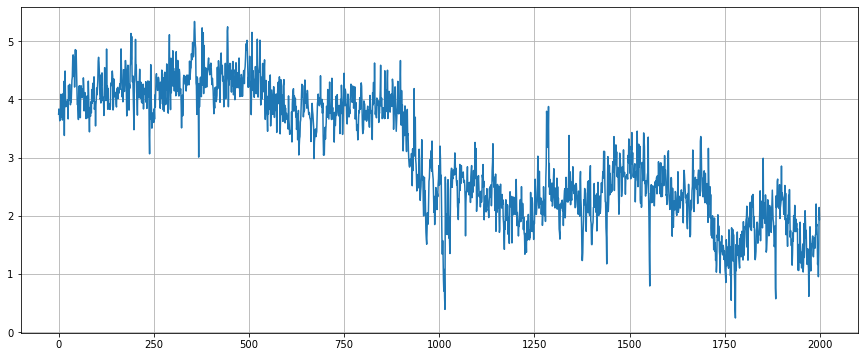

In [12]:
(df['当季']+df['次周']-2*df['当周']).dropna().plot(figsize=(15,6),grid=True)

In [13]:
class Exchange:
    def __init__(self, trade_symbols, leverage=20, maker_fee=0.0002,taker_fee=0.0004,log='',initial_balance=10000):
        self.initial_balance = initial_balance #初始的资产
        self.taker_fee = taker_fee
        self.maker_fee = maker_fee
        self.leverage = leverage
        self.trade_symbols = trade_symbols
        self.date = ''
        self.log = log
        self.df = pd.DataFrame()
        self.account = {'USDT':{'realised_profit':0, 'margin':0, 'unrealised_profit':0, 
                                'total':initial_balance, 'leverage':0, 'fee':0,'maker_fee':0,'taker_fee':0}}
        for symbol in trade_symbols:
            self.account[symbol] = {'amount':0, 'hold_price':0, 'value':0, 'price':0, 'realised_profit':0,
                                    'margin':0, 'unrealised_profit':0,'fee':0}
            
    def Trade(self, symbol, direction, price, amount, msg='', maker=True):
        
        if (self.date and symbol == self.log) or self.log == 'all':
            print('%-26s%-15s%-5s%-10.8s%-8.6s %s'%(str(self.date)[:24], symbol, 'buy' if direction == 1 else 'sell', price, amount, msg))

        cover_amount = 0 if direction*self.account[symbol]['amount'] >=0 else min(abs(self.account[symbol]['amount']), amount)
        open_amount = amount - cover_amount
        if maker:
            self.account['USDT']['realised_profit'] -= price*amount*self.maker_fee #扣除手续费
            self.account['USDT']['maker_fee'] += price*amount*self.maker_fee
            self.account['USDT']['fee'] += price*amount*self.maker_fee
            self.account[symbol]['fee'] += price*amount*self.maker_fee
        else:
            self.account['USDT']['realised_profit'] -= price*amount*self.taker_fee #扣除手续费
            self.account['USDT']['taker_fee'] += price*amount*self.taker_fee
            self.account['USDT']['fee'] += price*amount*self.taker_fee
            self.account[symbol]['fee'] += price*amount*self.taker_fee

        if cover_amount > 0: #先平仓
            self.account['USDT']['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount  #利润
            self.account['USDT']['margin'] -= cover_amount*self.account[symbol]['hold_price']/self.leverage #释放保证金
            
            self.account[symbol]['realised_profit'] += -direction*(price - self.account[symbol]['hold_price'])*cover_amount
            self.account[symbol]['amount'] -= -direction*cover_amount
            self.account[symbol]['margin'] -=  cover_amount*self.account[symbol]['hold_price']/self.leverage
            self.account[symbol]['hold_price'] = 0 if self.account[symbol]['amount'] == 0 else self.account[symbol]['hold_price']
            
        if open_amount > 0:
            total_cost = self.account[symbol]['hold_price']*direction*self.account[symbol]['amount'] + price*open_amount
            total_amount = direction*self.account[symbol]['amount']+open_amount
            
            self.account['USDT']['margin'] +=  open_amount*price/self.leverage            
            self.account[symbol]['hold_price'] = total_cost/total_amount
            self.account[symbol]['amount'] += direction*open_amount
            self.account[symbol]['margin'] +=  open_amount*price/self.leverage
            
        self.account[symbol]['unrealised_profit'] = (price - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
        self.account[symbol]['price'] = price
        self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*price
        
    
    def Buy(self, symbol, price, amount, msg='', maker=False):
        self.Trade(symbol, 1, price, amount, msg, maker)
        
    def Sell(self, symbol, price, amount, msg='', maker=False):
        self.Trade(symbol, -1, price, amount, msg,maker)
        

    def Update(self, date, symbols, close_price): #对资产进行更新
        self.date = date
        self.close = close_price
        self.account['USDT']['unrealised_profit'] = 0
        for symbol in symbols:
            self.account[symbol]['unrealised_profit'] = (close_price[symbol] - self.account[symbol]['hold_price'])*self.account[symbol]['amount']
            self.account[symbol]['price'] = close_price[symbol]
            self.account[symbol]['value'] = abs(self.account[symbol]['amount'])*close_price[symbol]
            
            self.account['USDT']['unrealised_profit'] += self.account[symbol]['unrealised_profit']
        self.account['USDT']['total'] = round(self.account['USDT']['realised_profit'] + self.initial_balance + self.account['USDT']['unrealised_profit'],6)
        self.account['USDT']['leverage'] = round(self.account['USDT']['margin']*self.leverage/self.account['USDT']['total'],4)

In [14]:
#trade_symbols = ['当季','当周','永续']
trade_symbols=['次周','当周','当季']
account = []

In [15]:
diff = df['当季']+df['次周']-2*df['当周']
diff_mean = diff.ewm(alpha=0.001).mean()

In [16]:
e = Exchange(trade_symbols,initial_balance=10000,taker_fee=0.0004)

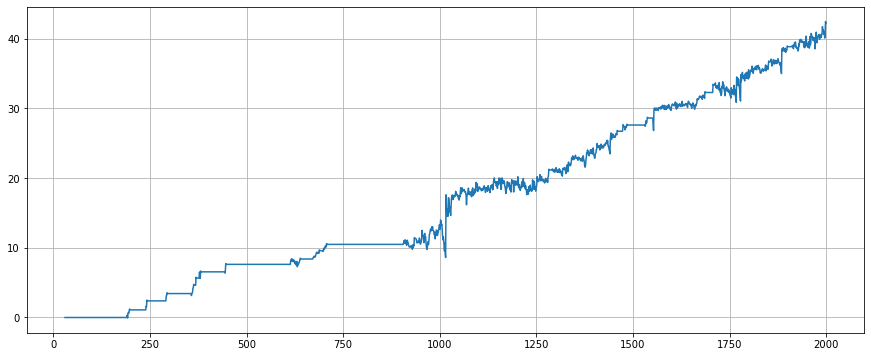

In [17]:
for row in df[trade_symbols].dropna().iloc[30:].iterrows():
    date = row[0]
    prices = row[1]
    e.Update(date, trade_symbols, prices)
    account.append([e.account['USDT']['margin'],e.account['USDT']['realised_profit']+e.account['USDT']['unrealised_profit']])
    aim_amount = -round((diff[date] - diff_mean[date])/(30*prices[trade_symbols[2]]*0.0004),1)
    now_amount = e.account[trade_symbols[2]]['amount']
    if aim_amount - now_amount < -1:
        trade_amount = 1
        e.Buy(trade_symbols[1],prices[trade_symbols[1]],2*trade_amount)
        e.Sell(trade_symbols[0],prices[trade_symbols[0]],trade_amount)
        e.Sell(trade_symbols[2],prices[trade_symbols[2]],trade_amount)
    if aim_amount - now_amount > 1:
        trade_amount = 1
        e.Sell(trade_symbols[1],prices[trade_symbols[1]],2*trade_amount)
        e.Buy(trade_symbols[0],prices[trade_symbols[0]],trade_amount)
        e.Buy(trade_symbols[2],prices[trade_symbols[2]],trade_amount)
e.df = pd.DataFrame(index=df[trade_symbols].dropna().iloc[30:].index,columns=['margin','profit'],data=account)
e.df['profit'].plot(figsize=(15,6),grid=True);

In [18]:
#获取永续合约行情深度数据
def get_perpetualdepth(symbol):
    url="https://api.btcgateway.pro/linear-swap-ex/market/depth?contract_code={}-USDT&type=step0".format(symbol.upper())
    res=requests.get(url)
    resdict=json.loads(res.content.decode())
    sell1=resdict['tick']['asks'][0][0]
    buy1=resdict['tick']['bids'][0][0]
    return [sell1,buy1]

In [19]:
#获取当周合约行情深度数据
def get_futuredepth(symbol,contract_type):
    contract_type_dict = {'this_week': 'CW', 'next_week': 'NW', 'quarter': 'CQ'}
    contract_type=contract_type_dict[contract_type]
    url="https://api.btcgateway.pro/market/depth?symbol={}_{}&type=step6".format(symbol.upper(),contract_type)
    res=requests.get(url)
    resdict=json.loads(res.content.decode())
    sell1=resdict['tick']['asks'][0][0]
    buy1=resdict['tick']['bids'][0][0]
    return [sell1,buy1]

In [20]:
import threading
class MyThread(threading.Thread):
    def __init__(self, func, args=()):
        super(MyThread, self).__init__()
        self.func = func
        self.args = args

    def run(self):
        self.result = self.func(*self.args)

    def get_result(self):
        try:
            return self.result  # 如果子线程不使用join方法，此处可能会报没有self.result的错误
        except Exception:
            return None

In [21]:
# 多线程获取合约行情深度价格
def get_all_contract_price(symbol):
    t1 = MyThread(get_futuredepth, args=(symbol, 'this_week',))
    t2 = MyThread(get_futuredepth, args=(symbol, 'quarter',))
    t3 = MyThread(get_perpetualdepth, args=(symbol,))
    t1.start()
    t2.start()
    t3.start()
    t1.join(timeout=10)
    t2.join(timeout=10)
    t3.join(timeout=10)
    depth_array1 = t1.get_result() #当周
    depth_array2 = t2.get_result() #当季
    depth_array3 = t3.get_result() #永续
    return depth_array1, depth_array2, depth_array3

In [22]:
# diff_mean=0
# Alpha=0.000001
# fee=0.0002
# while True:
#     depth_array1, depth_array2, depth_array3=get_all_contract_price('btc')
#     Grid=depth_array3[1]*fee*15
#     diff_sell=depth_array2[1]+depth_array3[1]-2*depth_array1[0]
#     diff_buy=depth_array2[0]+depth_array3[0]-2*depth_array1[1]
#     if not diff_mean:
#         diff_mean=(diff_buy+diff_sell)/2
#     else:
#         diff_mean=diff_mean*(1-Alpha)+Alpha*(diff_buy+diff_sell)/2
#     aim_buy_amount=-(diff_buy-diff_mean)/Grid
#     aim_sell_amount=-(diff_sell-diff_mean)/Grid
#     print(aim_buy_amount,aim_sell_amount)

In [23]:
# Grid=depth_array3[1]*fee*15
# print(diff_mean)
# aim_buy_amount=-(diff_buy-diff_mean)/Grid
# aim_sell_amount=-(diff_sell-diff_mean)/Grid
# print(aim_buy_amount,aim_sell_amount)

In [24]:
url="https://api.btcgateway.pro/linear-swap-api/v1/swap_contract_info?contract_code=FIL-USDT"

In [25]:
res=requests.get(url)

In [26]:
import json
resdict=json.loads(res.content.decode())
print(resdict)

{'status': 'ok', 'data': [{'symbol': 'FIL', 'contract_code': 'FIL-USDT', 'contract_size': 0.1, 'price_tick': 0.001, 'delivery_time': '', 'create_date': '20201021', 'contract_status': 1, 'settlement_date': '1624291200000', 'support_margin_mode': 'all'}], 'ts': 1624274302326}


In [27]:
url='https://api.btcgateway.pro/api/v1/contract_contract_info?symbol=FIL&contract_type=this_week'

In [28]:
res=requests.get(url)

In [29]:
import json
resdict=json.loads(res.content.decode())
print(resdict)

{'status': 'ok', 'data': [{'symbol': 'FIL', 'contract_code': 'FIL210625', 'contract_type': 'this_week', 'contract_size': 10.0, 'price_tick': 0.001, 'delivery_date': '20210625', 'delivery_time': '1624608000000', 'create_date': '20201211', 'contract_status': 1, 'settlement_time': '1624348800000'}], 'ts': 1624274303086}


In [30]:
#适合套利的币种
#FIL